In [1]:
!pip install mealpy
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import Conv2D,Input,MaxPooling2D,Flatten,Dense,Activation
from mealpy.swarm_based.GWO import OriginalGWO
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,Sequential

Defaulting to user installation because normal site-packages is not writeable


2024-07-02 04:18:48.761451: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 04:18:48.761547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 04:18:48.761580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 04:18:48.771968: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Model

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [10]:
from sklearn.preprocessing import StandardScaler

def scale_data(trainX, testX):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
 flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

 s = StandardScaler()
 # fit on training data
 s.fit(longX)
 # apply to training and test data
 longX = s.transform(longX)
 flatTrainX = s.transform(flatTrainX)
 flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX.shape))
 flatTestX = flatTestX.reshape((testX.shape))
 return flatTrainX, flatTestX

In [11]:
trainX, testX = scale_data(trainX, testX)

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [13]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

In [14]:
n_classes = 6

In [15]:
testX.shape

(2947, 128, 9)

In [16]:
testy_one_hot.shape

(2947, 6)

In [17]:
# checking the accuracy of the model before fine-tuning the parameters.

model =Sequential
i=Input(shape=(trainX.shape[1], trainX.shape[2]))
n=Conv1D(32,5,activation='relu',padding='same')(i)
n=MaxPooling1D(pool_size=2)(n)

n=Conv1D(64,3,activation='relu',padding='same')(n)
n=MaxPooling1D(pool_size=2,strides=2)(n)

n=Conv1D(96,3,activation='relu',padding='same')(n)
n=MaxPooling1D(pool_size=2,strides=2)(n)

n=Flatten()(n)
n=Dense(256,activation='relu')(n)
n=Dense(6,activation='softmax')(n)

model=Model(i,n)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d (Conv1D)             (None, 128, 32)           1472      
                                                                 
 max_pooling1d (MaxPooling1  (None, 64, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 32, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 96)            18528 

2024-07-02 04:18:55.093472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:48:00.0, compute capability: 8.0
2024-07-02 04:18:55.095931: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0


In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history =model.fit(trainX,trainy_one_hot, epochs=25,batch_size=32, validation_data=(testX, testy_one_hot))

Epoch 1/25


2024-07-02 04:18:56.571776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-07-02 04:18:56.893419: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8fed3e8720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-02 04:18:56.893487: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-07-02 04:18:56.893495: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-07-02 04:18:56.898971: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-02 04:18:56.987156: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


230/230 [==============================] - 4s 7ms/step - loss: 0.2770 - accuracy: 0.8894 - val_loss: 0.2405 - val_accuracy: 0.9087
Epoch 2/25
230/230 [==============================] - 1s 5ms/step - loss: 0.1116 - accuracy: 0.9514 - val_loss: 0.2785 - val_accuracy: 0.9063
Epoch 3/25
230/230 [==============================] - 1s 5ms/step - loss: 0.1114 - accuracy: 0.9548 - val_loss: 0.2174 - val_accuracy: 0.9304
Epoch 4/25
230/230 [==============================] - 1s 5ms/step - loss: 0.0910 - accuracy: 0.9621 - val_loss: 0.2558 - val_accuracy: 0.9182
Epoch 5/25
230/230 [==============================] - 1s 5ms/step - loss: 0.0909 - accuracy: 0.9631 - val_loss: 0.2833 - val_accuracy: 0.9220
Epoch 6/25
230/230 [==============================] - 1s 5ms/step - loss: 0.0850 - accuracy: 0.9648 - val_loss: 0.3128 - val_accuracy: 0.9175
Epoch 7/25
230/230 [==============================] - 1s 4ms/step - loss: 0.0704 - accuracy: 0.9686 - val_loss: 0.3431 - val_accuracy: 0.9175
Epoch 8/25
230/23

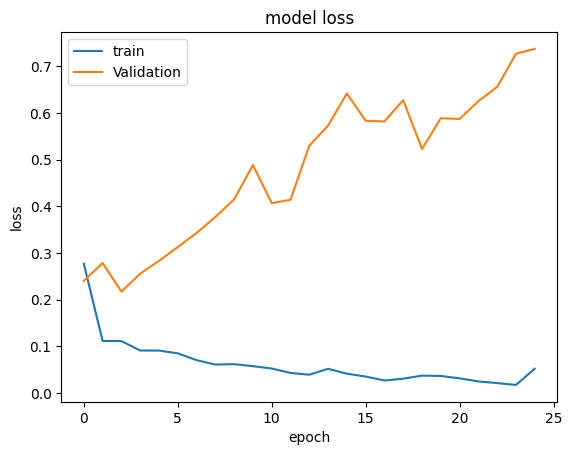

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

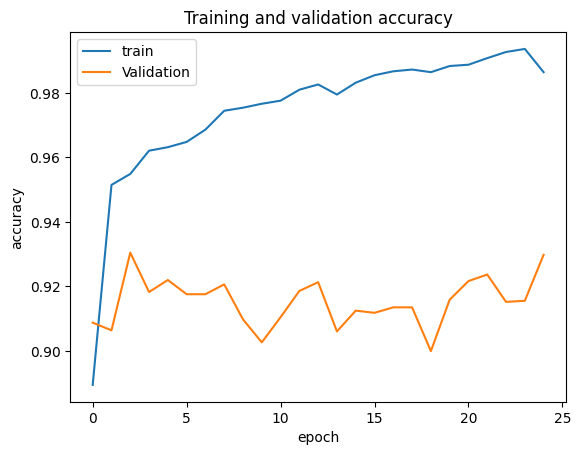

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 0s 1ms/step
0.9297590770274856
0.9297462801669438


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

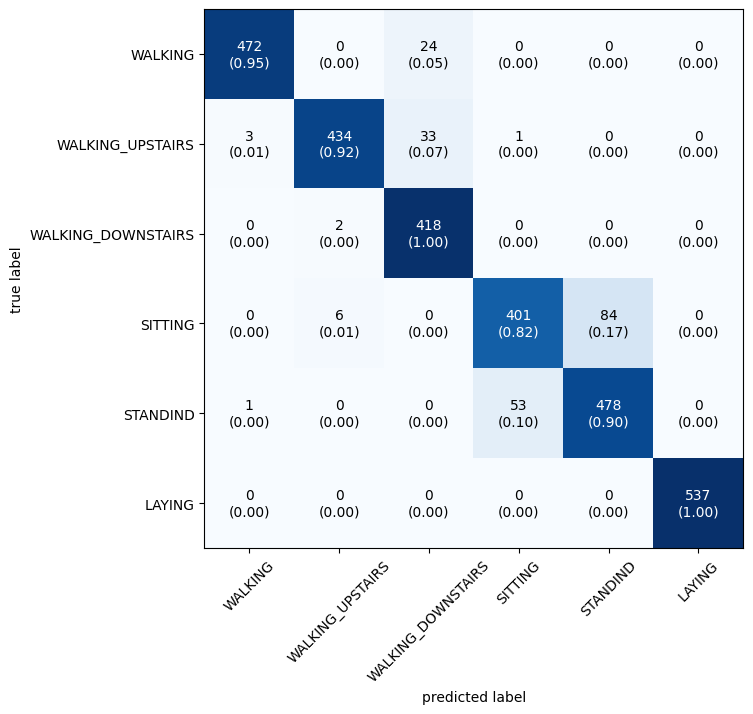

In [21]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# GWO 

In [22]:
from mealpy.swarm_based import GWO
from mealpy.utils.problem import Problem
from mealpy.utils.space import FloatVar, IntegerVar
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam

# GWO

def fitness_function(position):
    learning_rate, n1, n2, n3, n4, krnl_size, epochs = position
    n1, n2, n3, n4, krnl_size, epochs = int(n1), int(n2), int(n3), int(n4), int(krnl_size), int(epochs)
    print(learning_rate, n1, n2, n3, n4, krnl_size, epochs)
    model = Sequential()
    model.add(Conv1D(n1, krnl_size, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(n2, krnl_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(n3, krnl_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(n4, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(trainX, trainy_one_hot, epochs=int(epochs), batch_size=32, validation_data=(testX, testy_one_hot))
    return history.history['val_accuracy'][-1]

bounds = [
    FloatVar(0.001, 0.1),        # learning_rate
    IntegerVar(16, 32),          # n1
    IntegerVar(32, 64),          # n2
    IntegerVar(64, 128),         # n3
    IntegerVar(128, 512),        # n4
    IntegerVar(3, 5),            # krnl_size
    IntegerVar(5, 30),           # epochs
]

problem = Problem(
    obj_func=fitness_function,
    bounds=bounds,
    minmax="max"
)

# GWO instantiation and optimization
epoch = 20
pop_size = 5
gwo = GWO.OriginalGWO(epoch, pop_size)  # Correctly instantiate the GWO class
result = gwo.solve(problem)  # result는 Agent 객체

# result 객체의 속성 확인
print(dir(result))

# 적절한 속성 이름으로 최적의 위치와 피트니스 값을 추출
best_position = result.solution  # 혹은 result.position
best_fitness = result.target

print(f"Solution: {best_position}, Fitness: {best_fitness}")

0.06845956022289058 16 43 78 254 4 18
Epoch 1/18
230/230 [==============================] - 3s 5ms/step - loss: 6.1605 - accuracy: 0.1902 - val_loss: 1.7898 - val_accuracy: 0.1822
Epoch 2/18
230/230 [==============================] - 1s 4ms/step - loss: 1.7894 - accuracy: 0.1843 - val_loss: 1.7965 - val_accuracy: 0.1683
Epoch 3/18
230/230 [==============================] - 1s 5ms/step - loss: 1.7901 - accuracy: 0.1834 - val_loss: 1.7929 - val_accuracy: 0.1666
Epoch 4/18
230/230 [==============================] - 1s 5ms/step - loss: 1.7895 - accuracy: 0.1831 - val_loss: 1.7930 - val_accuracy: 0.1822
Epoch 5/18
230/230 [==============================] - 1s 5ms/step - loss: 1.7902 - accuracy: 0.1840 - val_loss: 1.7927 - val_accuracy: 0.1805
Epoch 6/18
230/230 [==============================] - 1s 5ms/step - loss: 1.7898 - accuracy: 0.1903 - val_loss: 1.8034 - val_accuracy: 0.1683
Epoch 7/18
230/230 [==============================] - 1s 5ms/step - loss: 1.7920 - accuracy: 0.1791 - val_loss

2024/07/02 04:19:49 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: Solving single objective optimization problem.


0.03171866565532297 23 37 121 483 3 12
Epoch 1/12
230/230 [==============================] - 3s 7ms/step - loss: 2.3263 - accuracy: 0.1863 - val_loss: 1.7924 - val_accuracy: 0.1666
Epoch 2/12
230/230 [==============================] - 1s 5ms/step - loss: 1.7869 - accuracy: 0.1915 - val_loss: 1.7967 - val_accuracy: 0.1805
Epoch 3/12
230/230 [==============================] - 1s 5ms/step - loss: 1.7876 - accuracy: 0.1870 - val_loss: 1.7893 - val_accuracy: 0.1805
Epoch 4/12
230/230 [==============================] - 1s 5ms/step - loss: 1.7868 - accuracy: 0.1861 - val_loss: 1.7949 - val_accuracy: 0.1822
Epoch 5/12
230/230 [==============================] - 1s 5ms/step - loss: 1.7866 - accuracy: 0.1882 - val_loss: 1.7896 - val_accuracy: 0.1805
Epoch 6/12
230/230 [==============================] - 1s 5ms/step - loss: 1.7875 - accuracy: 0.1829 - val_loss: 1.8005 - val_accuracy: 0.1822
Epoch 7/12
230/230 [==============================] - 1s 4ms/step - loss: 1.7873 - accuracy: 0.1946 - val_los

230/230 [==============================] - 1s 5ms/step - loss: 1.7898 - accuracy: 0.1874 - val_loss: 1.7920 - val_accuracy: 0.1822
Epoch 7/30
230/230 [==============================] - 1s 5ms/step - loss: 1.7892 - accuracy: 0.1870 - val_loss: 1.7934 - val_accuracy: 0.1822
Epoch 8/30
230/230 [==============================] - 1s 5ms/step - loss: 1.7891 - accuracy: 0.1829 - val_loss: 1.7945 - val_accuracy: 0.1805
Epoch 9/30
230/230 [==============================] - 1s 5ms/step - loss: 1.7895 - accuracy: 0.1831 - val_loss: 1.7957 - val_accuracy: 0.1822
Epoch 10/30
230/230 [==============================] - 1s 5ms/step - loss: 1.7893 - accuracy: 0.1829 - val_loss: 1.7981 - val_accuracy: 0.1822
Epoch 11/30
230/230 [==============================] - 1s 5ms/step - loss: 1.7896 - accuracy: 0.1862 - val_loss: 1.7947 - val_accuracy: 0.1805
Epoch 12/30
230/230 [==============================] - 1s 5ms/step - loss: 1.7890 - accuracy: 0.1857 - val_loss: 1.7913 - val_accuracy: 0.1822
Epoch 13/30
23

Epoch 15/26
230/230 [==============================] - 1s 5ms/step - loss: 0.0407 - accuracy: 0.9803 - val_loss: 0.6108 - val_accuracy: 0.9104
Epoch 16/26
230/230 [==============================] - 1s 5ms/step - loss: 0.0594 - accuracy: 0.9777 - val_loss: 0.6027 - val_accuracy: 0.8958
Epoch 17/26
230/230 [==============================] - 1s 5ms/step - loss: 0.0378 - accuracy: 0.9816 - val_loss: 0.6215 - val_accuracy: 0.9013
Epoch 18/26
230/230 [==============================] - 1s 5ms/step - loss: 0.0357 - accuracy: 0.9830 - val_loss: 0.6025 - val_accuracy: 0.8958
Epoch 19/26
230/230 [==============================] - 1s 5ms/step - loss: 0.0320 - accuracy: 0.9853 - val_loss: 0.6446 - val_accuracy: 0.9070
Epoch 20/26
230/230 [==============================] - 1s 5ms/step - loss: 0.0339 - accuracy: 0.9848 - val_loss: 0.5683 - val_accuracy: 0.9063
Epoch 21/26
230/230 [==============================] - 1s 5ms/step - loss: 0.0383 - accuracy: 0.9845 - val_loss: 0.6039 - val_accuracy: 0.8996

2024/07/02 04:23:21 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 0.9107567071914673, Global best: 0.9107567071914673, Runtime: 103.63161 seconds


0.002001672732748874 32 44 112 508 3 4
Epoch 1/4
230/230 [==============================] - 3s 6ms/step - loss: 0.2809 - accuracy: 0.8913 - val_loss: 0.2218 - val_accuracy: 0.9162
Epoch 2/4
230/230 [==============================] - 1s 5ms/step - loss: 0.1080 - accuracy: 0.9510 - val_loss: 0.4428 - val_accuracy: 0.8951
Epoch 3/4
230/230 [==============================] - 1s 5ms/step - loss: 0.1111 - accuracy: 0.9520 - val_loss: 0.3018 - val_accuracy: 0.9253
Epoch 4/4
230/230 [==============================] - 1s 5ms/step - loss: 0.0924 - accuracy: 0.9576 - val_loss: 0.3136 - val_accuracy: 0.9199
0.002498111651509769 15 44 128 147 2 20
Epoch 1/20
230/230 [==============================] - 3s 6ms/step - loss: 0.2868 - accuracy: 0.8889 - val_loss: 0.3714 - val_accuracy: 0.8975
Epoch 2/20
230/230 [==============================] - 1s 5ms/step - loss: 0.1144 - accuracy: 0.9514 - val_loss: 0.3335 - val_accuracy: 0.8728
Epoch 3/20
230/230 [==============================] - 1s 5ms/step - loss:

230/230 [==============================] - 1s 5ms/step - loss: 0.0978 - accuracy: 0.9582 - val_loss: 0.3212 - val_accuracy: 0.8965
Epoch 5/9
230/230 [==============================] - 1s 5ms/step - loss: 0.1089 - accuracy: 0.9520 - val_loss: 0.2989 - val_accuracy: 0.9172
Epoch 6/9
230/230 [==============================] - 1s 5ms/step - loss: 0.0868 - accuracy: 0.9622 - val_loss: 0.3034 - val_accuracy: 0.9182
Epoch 7/9
230/230 [==============================] - 1s 5ms/step - loss: 0.0778 - accuracy: 0.9634 - val_loss: 0.3794 - val_accuracy: 0.9196
Epoch 8/9
230/230 [==============================] - 1s 5ms/step - loss: 0.0725 - accuracy: 0.9663 - val_loss: 0.4466 - val_accuracy: 0.9074
Epoch 9/9
230/230 [==============================] - 1s 5ms/step - loss: 0.0886 - accuracy: 0.9619 - val_loss: 0.5493 - val_accuracy: 0.8466
0.009256164842669647 24 31 103 484 4 16
Epoch 1/16
230/230 [==============================] - 3s 6ms/step - loss: 0.3584 - accuracy: 0.8766 - val_loss: 0.2491 - val

2024/07/02 04:24:59 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 0.9222938418388367, Global best: 0.9222938418388367, Runtime: 98.37904 seconds


0.003071307840981301 32 64 112 512 4 13
Epoch 1/13
230/230 [==============================] - 3s 6ms/step - loss: 0.2593 - accuracy: 0.8992 - val_loss: 0.2788 - val_accuracy: 0.9087
Epoch 2/13
230/230 [==============================] - 1s 5ms/step - loss: 0.1324 - accuracy: 0.9426 - val_loss: 0.2081 - val_accuracy: 0.9199
Epoch 3/13
230/230 [==============================] - 1s 4ms/step - loss: 0.1002 - accuracy: 0.9563 - val_loss: 0.3271 - val_accuracy: 0.9220
Epoch 4/13
230/230 [==============================] - 1s 4ms/step - loss: 0.0915 - accuracy: 0.9565 - val_loss: 0.4682 - val_accuracy: 0.9091
Epoch 5/13
230/230 [==============================] - 1s 4ms/step - loss: 0.1688 - accuracy: 0.9441 - val_loss: 0.4026 - val_accuracy: 0.9009
Epoch 6/13
230/230 [==============================] - 1s 4ms/step - loss: 0.1096 - accuracy: 0.9557 - val_loss: 0.8007 - val_accuracy: 0.9094
Epoch 7/13
230/230 [==============================] - 1s 4ms/step - loss: 0.1320 - accuracy: 0.9518 - val_lo

230/230 [==============================] - 1s 5ms/step - loss: 0.0843 - accuracy: 0.9641 - val_loss: 0.6138 - val_accuracy: 0.9213
Epoch 6/21
230/230 [==============================] - 1s 5ms/step - loss: 0.1420 - accuracy: 0.9472 - val_loss: 0.2790 - val_accuracy: 0.9274
Epoch 7/21
230/230 [==============================] - 1s 5ms/step - loss: 0.1004 - accuracy: 0.9567 - val_loss: 0.3299 - val_accuracy: 0.9298
Epoch 8/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0828 - accuracy: 0.9646 - val_loss: 0.3313 - val_accuracy: 0.9301
Epoch 9/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0664 - accuracy: 0.9678 - val_loss: 0.4466 - val_accuracy: 0.9223
Epoch 10/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0669 - accuracy: 0.9678 - val_loss: 0.4203 - val_accuracy: 0.9345
Epoch 11/21
230/230 [==============================] - 1s 6ms/step - loss: 0.0667 - accuracy: 0.9689 - val_loss: 0.5181 - val_accuracy: 0.9250
Epoch 12/21
230

2024/07/02 04:26:42 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 0.9222938418388367, Global best: 0.9222938418388367, Runtime: 103.12857 seconds


0.002867993210243679 32 48 128 512 5 22
Epoch 1/22
230/230 [==============================] - 3s 6ms/step - loss: 0.2644 - accuracy: 0.8947 - val_loss: 0.2765 - val_accuracy: 0.9111
Epoch 2/22
230/230 [==============================] - 1s 5ms/step - loss: 0.1222 - accuracy: 0.9494 - val_loss: 0.4942 - val_accuracy: 0.8985
Epoch 3/22
230/230 [==============================] - 1s 5ms/step - loss: 0.0951 - accuracy: 0.9589 - val_loss: 0.5011 - val_accuracy: 0.9192
Epoch 4/22
230/230 [==============================] - 1s 5ms/step - loss: 0.0983 - accuracy: 0.9561 - val_loss: 0.7169 - val_accuracy: 0.9006
Epoch 5/22
230/230 [==============================] - 1s 5ms/step - loss: 0.1251 - accuracy: 0.9513 - val_loss: 0.3876 - val_accuracy: 0.9165
Epoch 6/22
230/230 [==============================] - 1s 5ms/step - loss: 0.1571 - accuracy: 0.9468 - val_loss: 0.4376 - val_accuracy: 0.9223
Epoch 7/22
230/230 [==============================] - 1s 5ms/step - loss: 0.0925 - accuracy: 0.9585 - val_lo

230/230 [==============================] - 1s 5ms/step - loss: 0.0629 - accuracy: 0.9695 - val_loss: 0.3442 - val_accuracy: 0.9304
Epoch 10/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0806 - accuracy: 0.9680 - val_loss: 0.3043 - val_accuracy: 0.9213
Epoch 11/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0646 - accuracy: 0.9701 - val_loss: 0.3250 - val_accuracy: 0.9287
Epoch 12/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0616 - accuracy: 0.9732 - val_loss: 0.2238 - val_accuracy: 0.9376
Epoch 13/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0536 - accuracy: 0.9748 - val_loss: 0.2936 - val_accuracy: 0.9291
Epoch 14/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0697 - accuracy: 0.9743 - val_loss: 0.2876 - val_accuracy: 0.9376
Epoch 15/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0680 - accuracy: 0.9712 - val_loss: 0.3852 - val_accuracy: 0.9162
Epoch 16/21

2024/07/02 04:28:57 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 0.9280624389648438, Global best: 0.9280624389648438, Runtime: 134.84324 seconds


0.0036934373649181937 32 58 127 237 2 14
Epoch 1/14
230/230 [==============================] - 3s 6ms/step - loss: 0.2893 - accuracy: 0.8913 - val_loss: 0.3438 - val_accuracy: 0.9101
Epoch 2/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1334 - accuracy: 0.9459 - val_loss: 0.2770 - val_accuracy: 0.8962
Epoch 3/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1204 - accuracy: 0.9547 - val_loss: 0.4033 - val_accuracy: 0.9033
Epoch 4/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1071 - accuracy: 0.9553 - val_loss: 0.2860 - val_accuracy: 0.9138
Epoch 5/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0874 - accuracy: 0.9611 - val_loss: 0.3112 - val_accuracy: 0.9277
Epoch 6/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1439 - accuracy: 0.9499 - val_loss: 0.3581 - val_accuracy: 0.9155
Epoch 7/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0842 - accuracy: 0.9606 - val_l

230/230 [==============================] - 1s 5ms/step - loss: 0.1203 - accuracy: 0.9527 - val_loss: 0.2808 - val_accuracy: 0.8955
Epoch 4/28
230/230 [==============================] - 1s 5ms/step - loss: 0.0996 - accuracy: 0.9565 - val_loss: 0.4568 - val_accuracy: 0.8833
Epoch 5/28
230/230 [==============================] - 1s 6ms/step - loss: 0.0861 - accuracy: 0.9630 - val_loss: 0.3015 - val_accuracy: 0.9182
Epoch 6/28
230/230 [==============================] - 1s 5ms/step - loss: 0.0746 - accuracy: 0.9648 - val_loss: 0.5783 - val_accuracy: 0.9091
Epoch 7/28
230/230 [==============================] - 1s 5ms/step - loss: 0.0724 - accuracy: 0.9635 - val_loss: 0.3395 - val_accuracy: 0.9220
Epoch 8/28
230/230 [==============================] - 1s 5ms/step - loss: 0.1732 - accuracy: 0.9521 - val_loss: 0.2913 - val_accuracy: 0.9182
Epoch 9/28
230/230 [==============================] - 1s 5ms/step - loss: 0.0831 - accuracy: 0.9634 - val_loss: 0.3530 - val_accuracy: 0.9131
Epoch 10/28
230/2

2024/07/02 04:30:46 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 108.37698 seconds


0.0028663514992724112 32 39 80 404 2 15
Epoch 1/15
230/230 [==============================] - 3s 6ms/step - loss: 0.2862 - accuracy: 0.8871 - val_loss: 0.2865 - val_accuracy: 0.9013
Epoch 2/15
230/230 [==============================] - 1s 5ms/step - loss: 0.1221 - accuracy: 0.9495 - val_loss: 0.4812 - val_accuracy: 0.9101
Epoch 3/15
230/230 [==============================] - 1s 5ms/step - loss: 0.1182 - accuracy: 0.9524 - val_loss: 0.2950 - val_accuracy: 0.9209
Epoch 4/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0978 - accuracy: 0.9566 - val_loss: 0.4467 - val_accuracy: 0.9114
Epoch 5/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0829 - accuracy: 0.9619 - val_loss: 0.4527 - val_accuracy: 0.9121
Epoch 6/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0782 - accuracy: 0.9637 - val_loss: 0.6034 - val_accuracy: 0.9097
Epoch 7/15
230/230 [==============================] - 1s 6ms/step - loss: 0.0942 - accuracy: 0.9622 - val_lo

230/230 [==============================] - 1s 4ms/step - loss: 0.1031 - accuracy: 0.9547 - val_loss: 0.2576 - val_accuracy: 0.9216
Epoch 5/9
230/230 [==============================] - 1s 4ms/step - loss: 0.0915 - accuracy: 0.9570 - val_loss: 0.3507 - val_accuracy: 0.9260
Epoch 6/9
230/230 [==============================] - 1s 4ms/step - loss: 0.0818 - accuracy: 0.9644 - val_loss: 0.4427 - val_accuracy: 0.9284
Epoch 7/9
230/230 [==============================] - 1s 5ms/step - loss: 0.0754 - accuracy: 0.9649 - val_loss: 0.4110 - val_accuracy: 0.9318
Epoch 8/9
230/230 [==============================] - 1s 4ms/step - loss: 0.0946 - accuracy: 0.9645 - val_loss: 0.3285 - val_accuracy: 0.9016
Epoch 9/9
230/230 [==============================] - 1s 4ms/step - loss: 0.0860 - accuracy: 0.9603 - val_loss: 0.3458 - val_accuracy: 0.9209


2024/07/02 04:31:58 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 71.86599 seconds


0.002582145569939813 28 37 128 201 3 15
Epoch 1/15
230/230 [==============================] - 3s 5ms/step - loss: 0.2571 - accuracy: 0.8976 - val_loss: 0.2473 - val_accuracy: 0.9216
Epoch 2/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1200 - accuracy: 0.9489 - val_loss: 0.2223 - val_accuracy: 0.9355
Epoch 3/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1004 - accuracy: 0.9546 - val_loss: 0.3043 - val_accuracy: 0.9091
Epoch 4/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1025 - accuracy: 0.9525 - val_loss: 0.2541 - val_accuracy: 0.9233
Epoch 5/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0831 - accuracy: 0.9592 - val_loss: 0.3156 - val_accuracy: 0.9376
Epoch 6/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0781 - accuracy: 0.9634 - val_loss: 0.2949 - val_accuracy: 0.9264
Epoch 7/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1062 - accuracy: 0.9578 - val_lo

230/230 [==============================] - 1s 4ms/step - loss: 0.1109 - accuracy: 0.9527 - val_loss: 0.3613 - val_accuracy: 0.9175
Epoch 3/23
230/230 [==============================] - 1s 4ms/step - loss: 0.1089 - accuracy: 0.9559 - val_loss: 0.6922 - val_accuracy: 0.8446
Epoch 4/23
230/230 [==============================] - 1s 4ms/step - loss: 0.1141 - accuracy: 0.9521 - val_loss: 0.2800 - val_accuracy: 0.9250
Epoch 5/23
230/230 [==============================] - 1s 4ms/step - loss: 0.0807 - accuracy: 0.9604 - val_loss: 0.3581 - val_accuracy: 0.9169
Epoch 6/23
230/230 [==============================] - 1s 4ms/step - loss: 0.1409 - accuracy: 0.9505 - val_loss: 0.3224 - val_accuracy: 0.9145
Epoch 7/23
230/230 [==============================] - 1s 4ms/step - loss: 0.0856 - accuracy: 0.9637 - val_loss: 0.5402 - val_accuracy: 0.9057
Epoch 8/23
230/230 [==============================] - 1s 4ms/step - loss: 0.0802 - accuracy: 0.9653 - val_loss: 0.5112 - val_accuracy: 0.9233
Epoch 9/23
230/23

2024/07/02 04:33:35 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 7, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 97.15645 seconds


0.0022140995974935605 30 39 64 128 5 14
Epoch 1/14
230/230 [==============================] - 3s 5ms/step - loss: 0.3008 - accuracy: 0.8803 - val_loss: 0.2330 - val_accuracy: 0.9070
Epoch 2/14
230/230 [==============================] - 1s 4ms/step - loss: 0.1118 - accuracy: 0.9521 - val_loss: 0.2034 - val_accuracy: 0.9148
Epoch 3/14
230/230 [==============================] - 1s 4ms/step - loss: 0.1118 - accuracy: 0.9520 - val_loss: 0.3005 - val_accuracy: 0.9121
Epoch 4/14
230/230 [==============================] - 1s 4ms/step - loss: 0.0992 - accuracy: 0.9554 - val_loss: 0.3018 - val_accuracy: 0.9226
Epoch 5/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0844 - accuracy: 0.9611 - val_loss: 0.2513 - val_accuracy: 0.9359
Epoch 6/14
230/230 [==============================] - 1s 4ms/step - loss: 0.1159 - accuracy: 0.9550 - val_loss: 0.2660 - val_accuracy: 0.9321
Epoch 7/14
230/230 [==============================] - 1s 4ms/step - loss: 0.1073 - accuracy: 0.9600 - val_lo

230/230 [==============================] - 1s 5ms/step - loss: 0.1091 - accuracy: 0.9509 - val_loss: 0.2287 - val_accuracy: 0.9277
Epoch 3/20
230/230 [==============================] - 1s 5ms/step - loss: 0.1253 - accuracy: 0.9487 - val_loss: 0.2728 - val_accuracy: 0.9097
Epoch 4/20
230/230 [==============================] - 1s 5ms/step - loss: 0.0983 - accuracy: 0.9566 - val_loss: 0.1904 - val_accuracy: 0.9311
Epoch 5/20
230/230 [==============================] - 1s 4ms/step - loss: 0.1074 - accuracy: 0.9531 - val_loss: 0.2322 - val_accuracy: 0.9257
Epoch 6/20
230/230 [==============================] - 1s 5ms/step - loss: 0.0864 - accuracy: 0.9599 - val_loss: 0.3091 - val_accuracy: 0.9226
Epoch 7/20
230/230 [==============================] - 1s 4ms/step - loss: 0.0753 - accuracy: 0.9659 - val_loss: 0.3087 - val_accuracy: 0.9287
Epoch 8/20
230/230 [==============================] - 1s 4ms/step - loss: 0.0711 - accuracy: 0.9649 - val_loss: 0.3067 - val_accuracy: 0.9237
Epoch 9/20
230/23

2024/07/02 04:34:58 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 8, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 83.60393 seconds


0.0026884359910536123 32 35 81 273 3 21
Epoch 1/21
230/230 [==============================] - 2s 5ms/step - loss: 0.2719 - accuracy: 0.8874 - val_loss: 0.2836 - val_accuracy: 0.9009
Epoch 2/21
230/230 [==============================] - 1s 4ms/step - loss: 0.1154 - accuracy: 0.9495 - val_loss: 0.3013 - val_accuracy: 0.9063
Epoch 3/21
230/230 [==============================] - 1s 4ms/step - loss: 0.1027 - accuracy: 0.9570 - val_loss: 0.3147 - val_accuracy: 0.9077
Epoch 4/21
230/230 [==============================] - 1s 5ms/step - loss: 0.1279 - accuracy: 0.9502 - val_loss: 0.2748 - val_accuracy: 0.8778
Epoch 5/21
230/230 [==============================] - 1s 4ms/step - loss: 0.0964 - accuracy: 0.9573 - val_loss: 0.3398 - val_accuracy: 0.9267
Epoch 6/21
230/230 [==============================] - 1s 4ms/step - loss: 0.0875 - accuracy: 0.9611 - val_loss: 0.3379 - val_accuracy: 0.9267
Epoch 7/21
230/230 [==============================] - 1s 4ms/step - loss: 0.1087 - accuracy: 0.9566 - val_lo

230/230 [==============================] - 1s 5ms/step - loss: 0.0481 - accuracy: 0.9785 - val_loss: 0.4032 - val_accuracy: 0.9233
Epoch 15/23
230/230 [==============================] - 1s 5ms/step - loss: 0.0413 - accuracy: 0.9820 - val_loss: 0.4547 - val_accuracy: 0.9175
Epoch 16/23
230/230 [==============================] - 1s 5ms/step - loss: 0.0619 - accuracy: 0.9770 - val_loss: 0.5610 - val_accuracy: 0.9135
Epoch 17/23
230/230 [==============================] - 1s 5ms/step - loss: 0.0591 - accuracy: 0.9782 - val_loss: 0.4429 - val_accuracy: 0.9301
Epoch 18/23
230/230 [==============================] - 1s 5ms/step - loss: 0.0526 - accuracy: 0.9770 - val_loss: 0.5436 - val_accuracy: 0.9253
Epoch 19/23
230/230 [==============================] - 1s 5ms/step - loss: 0.0387 - accuracy: 0.9830 - val_loss: 0.7096 - val_accuracy: 0.9145
Epoch 20/23
230/230 [==============================] - 1s 5ms/step - loss: 0.0359 - accuracy: 0.9859 - val_loss: 0.6030 - val_accuracy: 0.9125
Epoch 21/23

2024/07/02 04:36:55 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 9, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 117.14379 seconds


0.0023752577715702677 32 40 120 347 4 16
Epoch 1/16
230/230 [==============================] - 3s 5ms/step - loss: 0.2844 - accuracy: 0.8845 - val_loss: 0.2531 - val_accuracy: 0.9128
Epoch 2/16
230/230 [==============================] - 1s 4ms/step - loss: 0.1124 - accuracy: 0.9533 - val_loss: 0.3012 - val_accuracy: 0.9145
Epoch 3/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0964 - accuracy: 0.9562 - val_loss: 0.2904 - val_accuracy: 0.9162
Epoch 4/16
230/230 [==============================] - 1s 5ms/step - loss: 0.1015 - accuracy: 0.9569 - val_loss: 0.3849 - val_accuracy: 0.9040
Epoch 5/16
230/230 [==============================] - 1s 5ms/step - loss: 0.1367 - accuracy: 0.9476 - val_loss: 0.2273 - val_accuracy: 0.9287
Epoch 6/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0887 - accuracy: 0.9587 - val_loss: 0.2287 - val_accuracy: 0.9386
Epoch 7/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0814 - accuracy: 0.9615 - val_l

230/230 [==============================] - 1s 5ms/step - loss: 0.1329 - accuracy: 0.9471 - val_loss: 0.3381 - val_accuracy: 0.9046
Epoch 6/18
230/230 [==============================] - 1s 5ms/step - loss: 0.1006 - accuracy: 0.9576 - val_loss: 0.3155 - val_accuracy: 0.9158
Epoch 7/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0837 - accuracy: 0.9626 - val_loss: 0.4280 - val_accuracy: 0.9179
Epoch 8/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0942 - accuracy: 0.9582 - val_loss: 0.4815 - val_accuracy: 0.8829
Epoch 9/18
230/230 [==============================] - 1s 4ms/step - loss: 0.0908 - accuracy: 0.9614 - val_loss: 0.4009 - val_accuracy: 0.8996
Epoch 10/18
230/230 [==============================] - 1s 4ms/step - loss: 0.1427 - accuracy: 0.9634 - val_loss: 0.5332 - val_accuracy: 0.8728
Epoch 11/18
230/230 [==============================] - 1s 4ms/step - loss: 0.1421 - accuracy: 0.9521 - val_loss: 0.4795 - val_accuracy: 0.9175
Epoch 12/18
230

2024/07/02 04:38:36 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 10, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 100.98818 seconds


0.0022592012886959944 20 38 121 406 3 19
Epoch 1/19
230/230 [==============================] - 3s 5ms/step - loss: 0.3276 - accuracy: 0.8799 - val_loss: 0.2552 - val_accuracy: 0.9094
Epoch 2/19
230/230 [==============================] - 1s 5ms/step - loss: 0.1082 - accuracy: 0.9547 - val_loss: 0.2145 - val_accuracy: 0.9172
Epoch 3/19
230/230 [==============================] - 1s 5ms/step - loss: 0.0977 - accuracy: 0.9567 - val_loss: 0.2200 - val_accuracy: 0.9179
Epoch 4/19
230/230 [==============================] - 1s 5ms/step - loss: 0.1035 - accuracy: 0.9559 - val_loss: 0.3257 - val_accuracy: 0.9125
Epoch 5/19
230/230 [==============================] - 1s 5ms/step - loss: 0.0912 - accuracy: 0.9610 - val_loss: 0.2143 - val_accuracy: 0.9372
Epoch 6/19
230/230 [==============================] - 1s 6ms/step - loss: 0.0870 - accuracy: 0.9644 - val_loss: 0.3320 - val_accuracy: 0.9148
Epoch 7/19
230/230 [==============================] - 1s 5ms/step - loss: 0.0924 - accuracy: 0.9606 - val_l

230/230 [==============================] - 1s 5ms/step - loss: 0.0610 - accuracy: 0.9766 - val_loss: 0.3666 - val_accuracy: 0.9332
Epoch 19/25
230/230 [==============================] - 1s 5ms/step - loss: 0.0517 - accuracy: 0.9776 - val_loss: 0.3926 - val_accuracy: 0.9216
Epoch 20/25
230/230 [==============================] - 1s 4ms/step - loss: 0.1075 - accuracy: 0.9717 - val_loss: 0.5175 - val_accuracy: 0.9230
Epoch 21/25
230/230 [==============================] - 1s 5ms/step - loss: 0.0421 - accuracy: 0.9810 - val_loss: 0.5110 - val_accuracy: 0.9291
Epoch 22/25
230/230 [==============================] - 1s 5ms/step - loss: 0.0402 - accuracy: 0.9811 - val_loss: 0.5613 - val_accuracy: 0.9203
Epoch 23/25
230/230 [==============================] - 1s 5ms/step - loss: 0.0373 - accuracy: 0.9826 - val_loss: 0.5909 - val_accuracy: 0.9223
Epoch 24/25
230/230 [==============================] - 1s 5ms/step - loss: 0.0285 - accuracy: 0.9882 - val_loss: 0.7371 - val_accuracy: 0.9192
Epoch 25/25

2024/07/02 04:40:26 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 11, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 109.18257 seconds


0.0027377966596023374 24 45 128 445 2 20
Epoch 1/20
230/230 [==============================] - 3s 6ms/step - loss: 0.2806 - accuracy: 0.8993 - val_loss: 0.3407 - val_accuracy: 0.8968
Epoch 2/20
230/230 [==============================] - 1s 5ms/step - loss: 0.1239 - accuracy: 0.9489 - val_loss: 0.2937 - val_accuracy: 0.8972
Epoch 3/20
230/230 [==============================] - 1s 5ms/step - loss: 0.1054 - accuracy: 0.9539 - val_loss: 0.3069 - val_accuracy: 0.8999
Epoch 4/20
230/230 [==============================] - 1s 5ms/step - loss: 0.1077 - accuracy: 0.9550 - val_loss: 0.3385 - val_accuracy: 0.9192
Epoch 5/20
230/230 [==============================] - 1s 5ms/step - loss: 0.1078 - accuracy: 0.9569 - val_loss: 0.2950 - val_accuracy: 0.9237
Epoch 6/20
230/230 [==============================] - 1s 5ms/step - loss: 0.1278 - accuracy: 0.9542 - val_loss: 0.4345 - val_accuracy: 0.8751
Epoch 7/20
230/230 [==============================] - 1s 5ms/step - loss: 0.0971 - accuracy: 0.9596 - val_l

230/230 [==============================] - 1s 5ms/step - loss: 0.0746 - accuracy: 0.9739 - val_loss: 0.4614 - val_accuracy: 0.9097
Epoch 14/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0526 - accuracy: 0.9751 - val_loss: 0.4870 - val_accuracy: 0.9162
Epoch 15/18
230/230 [==============================] - 1s 4ms/step - loss: 0.0407 - accuracy: 0.9822 - val_loss: 0.5330 - val_accuracy: 0.8982
Epoch 16/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0378 - accuracy: 0.9823 - val_loss: 0.6810 - val_accuracy: 0.9091
Epoch 17/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0349 - accuracy: 0.9841 - val_loss: 0.5040 - val_accuracy: 0.9220
Epoch 18/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0586 - accuracy: 0.9778 - val_loss: 0.7865 - val_accuracy: 0.8958
0.00242147711113636 21 34 108 362 2 15
Epoch 1/15
230/230 [==============================] - 3s 6ms/step - loss: 0.2715 - accuracy: 0.8973 - val_loss: 0.3

2024/07/02 04:42:36 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 12, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 130.77144 seconds


0.0026145854504445506 25 38 115 342 3 18
Epoch 1/18
230/230 [==============================] - 3s 5ms/step - loss: 0.2604 - accuracy: 0.8995 - val_loss: 0.2655 - val_accuracy: 0.9108
Epoch 2/18
230/230 [==============================] - 1s 4ms/step - loss: 0.1070 - accuracy: 0.9559 - val_loss: 0.3507 - val_accuracy: 0.9196
Epoch 3/18
230/230 [==============================] - 1s 4ms/step - loss: 0.1269 - accuracy: 0.9508 - val_loss: 0.4052 - val_accuracy: 0.9111
Epoch 4/18
230/230 [==============================] - 1s 4ms/step - loss: 0.0928 - accuracy: 0.9600 - val_loss: 0.4307 - val_accuracy: 0.9006
Epoch 5/18
230/230 [==============================] - 1s 4ms/step - loss: 0.0912 - accuracy: 0.9606 - val_loss: 0.3700 - val_accuracy: 0.9192
Epoch 6/18
230/230 [==============================] - 1s 4ms/step - loss: 0.0832 - accuracy: 0.9659 - val_loss: 0.3783 - val_accuracy: 0.8996
Epoch 7/18
230/230 [==============================] - 1s 4ms/step - loss: 0.0950 - accuracy: 0.9593 - val_l

230/230 [==============================] - 1s 4ms/step - loss: 0.0426 - accuracy: 0.9784 - val_loss: 0.8602 - val_accuracy: 0.9016
Epoch 18/21
230/230 [==============================] - 1s 4ms/step - loss: 0.0963 - accuracy: 0.9680 - val_loss: 0.6052 - val_accuracy: 0.9077
Epoch 19/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0579 - accuracy: 0.9737 - val_loss: 0.6097 - val_accuracy: 0.9016
Epoch 20/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0413 - accuracy: 0.9812 - val_loss: 0.7410 - val_accuracy: 0.9152
Epoch 21/21
230/230 [==============================] - 1s 5ms/step - loss: 0.0408 - accuracy: 0.9814 - val_loss: 0.7139 - val_accuracy: 0.9223
0.002217471363817836 28 37 125 483 2 16
Epoch 1/16
230/230 [==============================] - 3s 6ms/step - loss: 0.3239 - accuracy: 0.8753 - val_loss: 0.3543 - val_accuracy: 0.8860
Epoch 2/16
230/230 [==============================] - 1s 5ms/step - loss: 0.1053 - accuracy: 0.9532 - val_loss: 0.2

2024/07/02 04:44:27 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 13, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 110.15343 seconds


0.0025380647442673093 26 40 128 512 3 16
Epoch 1/16
230/230 [==============================] - 3s 5ms/step - loss: 0.2881 - accuracy: 0.8936 - val_loss: 0.3292 - val_accuracy: 0.9097
Epoch 2/16
230/230 [==============================] - 1s 5ms/step - loss: 0.1067 - accuracy: 0.9542 - val_loss: 0.2847 - val_accuracy: 0.9301
Epoch 3/16
230/230 [==============================] - 1s 5ms/step - loss: 0.1066 - accuracy: 0.9546 - val_loss: 0.4777 - val_accuracy: 0.8867
Epoch 4/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0887 - accuracy: 0.9588 - val_loss: 0.4153 - val_accuracy: 0.9206
Epoch 5/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0864 - accuracy: 0.9611 - val_loss: 0.3406 - val_accuracy: 0.9226
Epoch 6/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0900 - accuracy: 0.9600 - val_loss: 0.4936 - val_accuracy: 0.9111
Epoch 7/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0857 - accuracy: 0.9625 - val_l

230/230 [==============================] - 1s 5ms/step - loss: 0.0698 - accuracy: 0.9680 - val_loss: 0.4044 - val_accuracy: 0.9308
Epoch 10/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0654 - accuracy: 0.9708 - val_loss: 0.4051 - val_accuracy: 0.9362
Epoch 11/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0575 - accuracy: 0.9723 - val_loss: 0.4688 - val_accuracy: 0.9260
Epoch 12/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0579 - accuracy: 0.9727 - val_loss: 0.5221 - val_accuracy: 0.9237
Epoch 13/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0746 - accuracy: 0.9703 - val_loss: 1.3405 - val_accuracy: 0.8531
Epoch 14/18
230/230 [==============================] - 1s 5ms/step - loss: 0.1179 - accuracy: 0.9607 - val_loss: 0.4588 - val_accuracy: 0.9182
Epoch 15/18
230/230 [==============================] - 1s 5ms/step - loss: 0.0535 - accuracy: 0.9728 - val_loss: 0.4583 - val_accuracy: 0.9223
Epoch 16/18

2024/07/02 04:46:06 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 14, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 99.77558 seconds


0.0024609004422277117 29 32 119 292 2 15
Epoch 1/15
230/230 [==============================] - 2s 5ms/step - loss: 0.2979 - accuracy: 0.8836 - val_loss: 0.3104 - val_accuracy: 0.9101
Epoch 2/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1127 - accuracy: 0.9527 - val_loss: 0.3292 - val_accuracy: 0.8989
Epoch 3/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1112 - accuracy: 0.9504 - val_loss: 0.4126 - val_accuracy: 0.9033
Epoch 4/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0937 - accuracy: 0.9567 - val_loss: 0.3171 - val_accuracy: 0.9213
Epoch 5/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0907 - accuracy: 0.9616 - val_loss: 0.5306 - val_accuracy: 0.9013
Epoch 6/15
230/230 [==============================] - 1s 5ms/step - loss: 0.1054 - accuracy: 0.9544 - val_loss: 0.5772 - val_accuracy: 0.9121
Epoch 7/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0813 - accuracy: 0.9631 - val_l

230/230 [==============================] - 1s 5ms/step - loss: 0.1274 - accuracy: 0.9634 - val_loss: 0.5263 - val_accuracy: 0.9104
Epoch 15/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0560 - accuracy: 0.9746 - val_loss: 0.6860 - val_accuracy: 0.9206
Epoch 16/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0552 - accuracy: 0.9744 - val_loss: 0.5208 - val_accuracy: 0.9162
0.002568854358747726 26 43 128 455 2 17
Epoch 1/17
230/230 [==============================] - 3s 6ms/step - loss: 0.2738 - accuracy: 0.8897 - val_loss: 0.2576 - val_accuracy: 0.9189
Epoch 2/17
230/230 [==============================] - 1s 4ms/step - loss: 0.1145 - accuracy: 0.9499 - val_loss: 0.3058 - val_accuracy: 0.9186
Epoch 3/17
230/230 [==============================] - 1s 4ms/step - loss: 0.0878 - accuracy: 0.9582 - val_loss: 0.3200 - val_accuracy: 0.9332
Epoch 4/17
230/230 [==============================] - 1s 4ms/step - loss: 0.1358 - accuracy: 0.9474 - val_loss: 0.292

2024/07/02 04:47:38 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 15, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 91.29212 seconds


0.00216981348827376 23 42 128 443 2 16
Epoch 1/16
230/230 [==============================] - 4s 6ms/step - loss: 0.3062 - accuracy: 0.8770 - val_loss: 0.2553 - val_accuracy: 0.9094
Epoch 2/16
230/230 [==============================] - 1s 4ms/step - loss: 0.1087 - accuracy: 0.9527 - val_loss: 0.2834 - val_accuracy: 0.9036
Epoch 3/16
230/230 [==============================] - 1s 5ms/step - loss: 0.1025 - accuracy: 0.9548 - val_loss: 0.3074 - val_accuracy: 0.9243
Epoch 4/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0915 - accuracy: 0.9572 - val_loss: 0.3188 - val_accuracy: 0.9253
Epoch 5/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0763 - accuracy: 0.9641 - val_loss: 0.3326 - val_accuracy: 0.9182
Epoch 6/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0697 - accuracy: 0.9686 - val_loss: 0.4345 - val_accuracy: 0.9169
Epoch 7/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0847 - accuracy: 0.9641 - val_los

230/230 [==============================] - 1s 5ms/step - loss: 0.0642 - accuracy: 0.9699 - val_loss: 0.3025 - val_accuracy: 0.9274
Epoch 11/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0711 - accuracy: 0.9686 - val_loss: 0.3514 - val_accuracy: 0.9121
Epoch 12/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0985 - accuracy: 0.9608 - val_loss: 0.5228 - val_accuracy: 0.9284
Epoch 13/16
230/230 [==============================] - 1s 5ms/step - loss: 0.1943 - accuracy: 0.9536 - val_loss: 0.2708 - val_accuracy: 0.9274
Epoch 14/16
230/230 [==============================] - 1s 4ms/step - loss: 0.0751 - accuracy: 0.9667 - val_loss: 0.3740 - val_accuracy: 0.9175
Epoch 15/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0618 - accuracy: 0.9713 - val_loss: 0.4836 - val_accuracy: 0.9250
Epoch 16/16
230/230 [==============================] - 1s 5ms/step - loss: 0.0530 - accuracy: 0.9757 - val_loss: 0.4698 - val_accuracy: 0.9284
0.002853865

2024/07/02 04:49:18 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 16, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 99.94914 seconds


0.0027181734180416386 32 44 124 428 2 14
Epoch 1/14
230/230 [==============================] - 3s 6ms/step - loss: 0.2767 - accuracy: 0.8935 - val_loss: 0.2993 - val_accuracy: 0.8968
Epoch 2/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1163 - accuracy: 0.9468 - val_loss: 0.3246 - val_accuracy: 0.9182
Epoch 3/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0948 - accuracy: 0.9592 - val_loss: 0.3159 - val_accuracy: 0.9250
Epoch 4/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0844 - accuracy: 0.9614 - val_loss: 0.4203 - val_accuracy: 0.9077
Epoch 5/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1205 - accuracy: 0.9528 - val_loss: 0.3210 - val_accuracy: 0.9165
Epoch 6/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0812 - accuracy: 0.9622 - val_loss: 0.4285 - val_accuracy: 0.9223
Epoch 7/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0766 - accuracy: 0.9649 - val_l

230/230 [==============================] - 1s 5ms/step - loss: 0.0972 - accuracy: 0.9593 - val_loss: 0.4785 - val_accuracy: 0.9033
Epoch 5/13
230/230 [==============================] - 1s 5ms/step - loss: 0.0865 - accuracy: 0.9629 - val_loss: 0.5283 - val_accuracy: 0.8965
Epoch 6/13
230/230 [==============================] - 1s 5ms/step - loss: 0.0760 - accuracy: 0.9660 - val_loss: 0.4318 - val_accuracy: 0.9145
Epoch 7/13
230/230 [==============================] - 1s 5ms/step - loss: 0.0711 - accuracy: 0.9687 - val_loss: 0.5848 - val_accuracy: 0.9192
Epoch 8/13
230/230 [==============================] - 1s 5ms/step - loss: 0.0919 - accuracy: 0.9671 - val_loss: 0.5231 - val_accuracy: 0.9274
Epoch 9/13
230/230 [==============================] - 1s 5ms/step - loss: 0.0773 - accuracy: 0.9663 - val_loss: 0.4010 - val_accuracy: 0.9321
Epoch 10/13
230/230 [==============================] - 1s 5ms/step - loss: 0.1031 - accuracy: 0.9634 - val_loss: 0.5007 - val_accuracy: 0.9192
Epoch 11/13
230/

2024/07/02 04:50:45 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 17, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 87.63291 seconds


0.0026941230072071065 29 42 128 444 2 14
Epoch 1/14
230/230 [==============================] - 3s 6ms/step - loss: 0.2704 - accuracy: 0.8985 - val_loss: 0.2406 - val_accuracy: 0.9057
Epoch 2/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1039 - accuracy: 0.9529 - val_loss: 0.2176 - val_accuracy: 0.9199
Epoch 3/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0955 - accuracy: 0.9566 - val_loss: 0.2368 - val_accuracy: 0.9233
Epoch 4/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1143 - accuracy: 0.9517 - val_loss: 0.3332 - val_accuracy: 0.9237
Epoch 5/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1017 - accuracy: 0.9561 - val_loss: 0.3705 - val_accuracy: 0.9138
Epoch 6/14
230/230 [==============================] - 1s 4ms/step - loss: 0.0847 - accuracy: 0.9595 - val_loss: 0.3259 - val_accuracy: 0.9114
Epoch 7/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0949 - accuracy: 0.9593 - val_l

230/230 [==============================] - 1s 4ms/step - loss: 0.0664 - accuracy: 0.9735 - val_loss: 0.4548 - val_accuracy: 0.9203
Epoch 15/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0968 - accuracy: 0.9678 - val_loss: 0.5856 - val_accuracy: 0.9158
0.0026503054629050797 30 41 127 479 2 15
Epoch 1/15
230/230 [==============================] - 3s 5ms/step - loss: 0.2707 - accuracy: 0.8984 - val_loss: 0.2160 - val_accuracy: 0.9148
Epoch 2/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1125 - accuracy: 0.9528 - val_loss: 0.3431 - val_accuracy: 0.9057
Epoch 3/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0980 - accuracy: 0.9578 - val_loss: 0.2756 - val_accuracy: 0.9308
Epoch 4/15
230/230 [==============================] - 1s 5ms/step - loss: 0.1147 - accuracy: 0.9536 - val_loss: 0.6923 - val_accuracy: 0.8612
Epoch 5/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0841 - accuracy: 0.9638 - val_loss: 0.285

2024/07/02 04:52:17 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 18, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 91.41442 seconds


0.002578073039034686 30 42 126 466 2 15
Epoch 1/15
230/230 [==============================] - 3s 6ms/step - loss: 0.2773 - accuracy: 0.8987 - val_loss: 0.2023 - val_accuracy: 0.9118
Epoch 2/15
230/230 [==============================] - 1s 5ms/step - loss: 0.1205 - accuracy: 0.9493 - val_loss: 0.2529 - val_accuracy: 0.9091
Epoch 3/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0979 - accuracy: 0.9573 - val_loss: 0.2128 - val_accuracy: 0.9270
Epoch 4/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0871 - accuracy: 0.9622 - val_loss: 0.2376 - val_accuracy: 0.9175
Epoch 5/15
230/230 [==============================] - 1s 5ms/step - loss: 0.1222 - accuracy: 0.9518 - val_loss: 0.2375 - val_accuracy: 0.9281
Epoch 6/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0737 - accuracy: 0.9663 - val_loss: 0.2448 - val_accuracy: 0.9257
Epoch 7/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0646 - accuracy: 0.9698 - val_lo

230/230 [==============================] - 1s 5ms/step - loss: 0.1005 - accuracy: 0.9661 - val_loss: 0.8178 - val_accuracy: 0.9158
Epoch 15/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0645 - accuracy: 0.9732 - val_loss: 0.7934 - val_accuracy: 0.9145
0.0026012578650125473 30 42 126 462 2 14
Epoch 1/14
230/230 [==============================] - 2s 5ms/step - loss: 0.2473 - accuracy: 0.9017 - val_loss: 0.2336 - val_accuracy: 0.9141
Epoch 2/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1035 - accuracy: 0.9548 - val_loss: 0.4297 - val_accuracy: 0.8863
Epoch 3/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1198 - accuracy: 0.9520 - val_loss: 0.3184 - val_accuracy: 0.9114
Epoch 4/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0882 - accuracy: 0.9623 - val_loss: 0.3439 - val_accuracy: 0.9036
Epoch 5/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0814 - accuracy: 0.9621 - val_loss: 0.410

2024/07/02 04:53:43 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 19, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 85.95655 seconds


0.002605561069564264 30 42 126 464 2 14
Epoch 1/14
230/230 [==============================] - 2s 5ms/step - loss: 0.3228 - accuracy: 0.8777 - val_loss: 0.3501 - val_accuracy: 0.9013
Epoch 2/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1151 - accuracy: 0.9505 - val_loss: 0.2799 - val_accuracy: 0.9101
Epoch 3/14
230/230 [==============================] - 1s 4ms/step - loss: 0.1166 - accuracy: 0.9480 - val_loss: 0.2689 - val_accuracy: 0.8996
Epoch 4/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0889 - accuracy: 0.9569 - val_loss: 0.3862 - val_accuracy: 0.9094
Epoch 5/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0771 - accuracy: 0.9635 - val_loss: 0.4517 - val_accuracy: 0.9077
Epoch 6/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0888 - accuracy: 0.9606 - val_loss: 0.5019 - val_accuracy: 0.9036
Epoch 7/14
230/230 [==============================] - 1s 5ms/step - loss: 0.1122 - accuracy: 0.9542 - val_lo

230/230 [==============================] - 2s 6ms/step - loss: 0.3223 - accuracy: 0.8730 - val_loss: 0.3273 - val_accuracy: 0.8897
Epoch 2/14
230/230 [==============================] - 1s 4ms/step - loss: 0.1161 - accuracy: 0.9508 - val_loss: 0.2386 - val_accuracy: 0.9237
Epoch 3/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0930 - accuracy: 0.9585 - val_loss: 0.3203 - val_accuracy: 0.9209
Epoch 4/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0960 - accuracy: 0.9573 - val_loss: 0.3503 - val_accuracy: 0.9175
Epoch 5/14
230/230 [==============================] - 1s 4ms/step - loss: 0.0861 - accuracy: 0.9606 - val_loss: 0.2913 - val_accuracy: 0.9223
Epoch 6/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0708 - accuracy: 0.9674 - val_loss: 0.2609 - val_accuracy: 0.9352
Epoch 7/14
230/230 [==============================] - 1s 5ms/step - loss: 0.0736 - accuracy: 0.9672 - val_loss: 0.3263 - val_accuracy: 0.9118
Epoch 8/14
230/23

2024/07/02 04:55:07 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 20, Current best: 0.9362063407897949, Global best: 0.9362063407897949, Runtime: 84.56446 seconds


['ID', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'compare_duplicate', 'copy', 'get_better_solution', 'id', 'increase', 'is_better_than', 'is_duplicate', 'kwargs', 'set_kwargs', 'solution', 'target', 'update', 'update_agent']
Solution: [2.94890638e-03 3.24999000e+01 4.81715067e+01 1.28499900e+02
 4.31868460e+02 2.50000000e+00 1.33245760e+01], Fitness: Objectives: [0.93620634], Fitness: 0.9362063407897949


# best parameters

In [35]:
learning_rate = 2.94890638e-03
n1 = int(3.24999000e+01)
n2 = int(4.81715067e+01)
n3 = int(1.28499900e+02)
n4 = int(4.31868460e+02)
krnl_size = int(2.50000000e+00)
epochs = int(1.33245760e+01)

In [36]:
# checking the accuracy of the model before fine-tuning the parameters.

model =Sequential
i=Input(shape=(trainX.shape[1], trainX.shape[2]))
n=Conv1D(n1,krnl_size, activation='relu',padding='same')(i)
n=MaxPooling1D(pool_size=2)(n)

n=Conv1D(n2,krnl_size, activation='relu',padding='same')(n)
n=MaxPooling1D(pool_size=2,strides=2)(n)

n=Conv1D(n3,krnl_size,activation='relu',padding='same')(n)
n=MaxPooling1D(pool_size=2,strides=2)(n)

n=Flatten()(n)
n=Dense(n4,activation='relu')(n)
n=Dense(6,activation='softmax')(n)

model=Model(i,n)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d_327 (Conv1D)         (None, 128, 32)           608       
                                                                 
 max_pooling1d_327 (MaxPool  (None, 64, 32)            0         
 ing1D)                                                          
                                                                 
 conv1d_328 (Conv1D)         (None, 64, 48)            3120      
                                                                 
 max_pooling1d_328 (MaxPool  (None, 32, 48)            0         
 ing1D)                                                          
                                                                 
 conv1d_329 (Conv1D)         (None, 32, 128)           1241

In [37]:
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history =model.fit(trainX,trainy_one_hot, epochs = epochs,batch_size=32, validation_data=(testX, testy_one_hot))

Epoch 1/13
230/230 [==============================] - 2s 6ms/step - loss: 0.2583 - accuracy: 0.9029 - val_loss: 0.2820 - val_accuracy: 0.8935
Epoch 2/13
230/230 [==============================] - 1s 5ms/step - loss: 0.1129 - accuracy: 0.9525 - val_loss: 0.4019 - val_accuracy: 0.8992
Epoch 3/13
230/230 [==============================] - 1s 5ms/step - loss: 0.1008 - accuracy: 0.9550 - val_loss: 0.5576 - val_accuracy: 0.9131
Epoch 4/13
230/230 [==============================] - 1s 5ms/step - loss: 0.1014 - accuracy: 0.9539 - val_loss: 0.5611 - val_accuracy: 0.8979
Epoch 5/13
230/230 [==============================] - 1s 5ms/step - loss: 0.0822 - accuracy: 0.9607 - val_loss: 0.6311 - val_accuracy: 0.9016
Epoch 6/13
230/230 [==============================] - 1s 5ms/step - loss: 0.0725 - accuracy: 0.9661 - val_loss: 0.6381 - val_accuracy: 0.9080
Epoch 7/13
230/230 [==============================] - 1s 5ms/step - loss: 0.0756 - accuracy: 0.9652 - val_loss: 0.7951 - val_accuracy: 0.8935
Epoch 

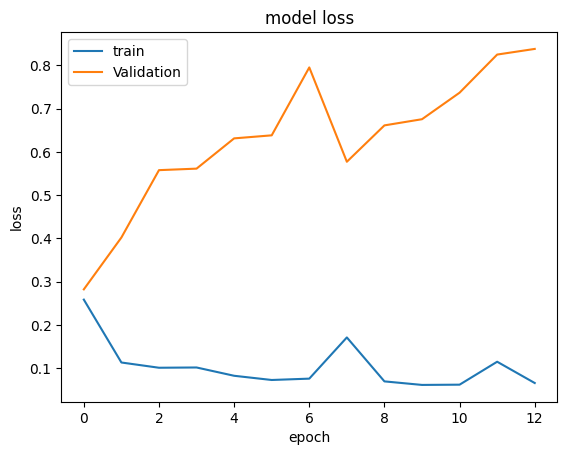

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

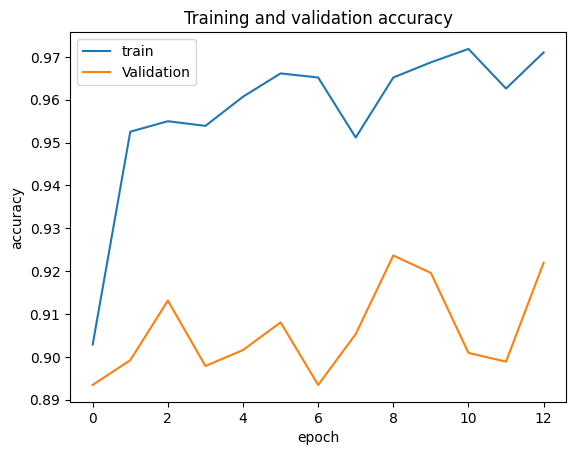

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 0s 1ms/step
0.9219545300305395
0.9212999727102628


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

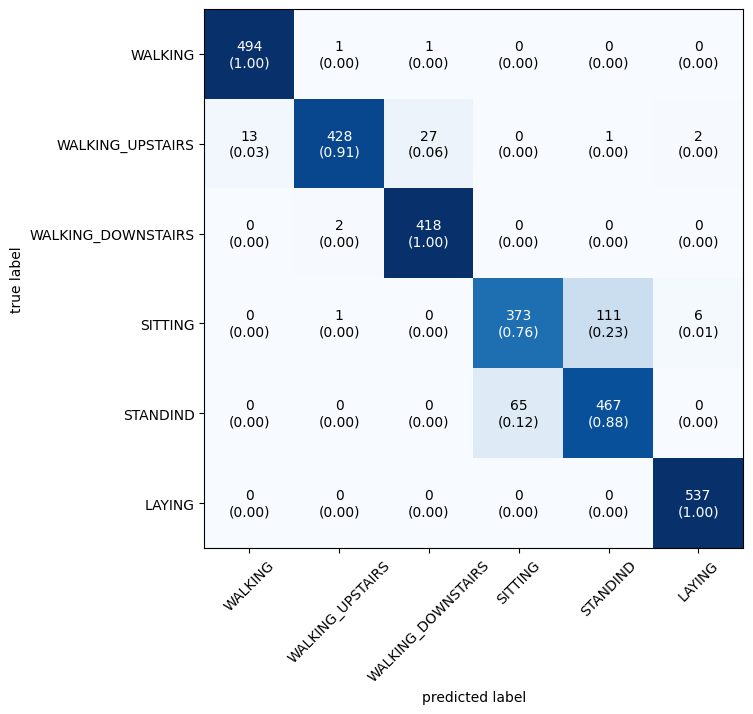

In [40]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))